In [1]:
import numpy as np
from random import random, uniform, seed
from scipy.interpolate import interp1d
import matplotlib.pyplot as plt
import pandas as pd
%matplotlib inline
import os

In [2]:
data = np.loadtxt('Nbody0.01.txt')

In [3]:
for i in range(3,10):
    try:
        newdata = np.loadtxt('Nbody{0}.txt'.format(10**(-i)))
        for row in newdata:
            replaceseed = int(row[0])
            data[replaceseed] = row
    except:
        pass

In [4]:
seeds, Nbodymind1s, Nbodymind2s, mind0s, mratios, ebinarys, codes = data.T
seeds = np.array([int(seed) for seed in seeds])

# Check that all the mind values got updated from their initial value. Sum should be 0

In [5]:
(Nbodymind1s==mind0s).sum()

0

In [6]:
(Nbodymind2s==mind0s).sum()

0

# Distributions of outcomes. 0 = survived, 1 = collision, 2 = ejection

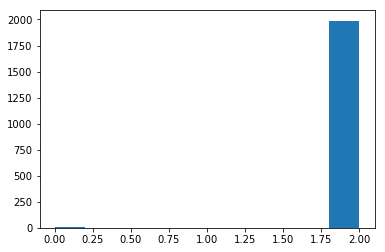

In [7]:
bins, vals, patches = plt.hist(codes)

In [8]:
print("{0}/{1} = {2:.4f} survived".format((codes==0).sum(), len(codes), (codes==0).sum()/float(len(codes))))
print("{0}/{1} = {2:.4f} collided".format((codes==1).sum(), len(codes), (codes==1).sum()/float(len(codes))))
print("{0}/{1} = {2:.4f} ejected".format((codes==2).sum(), len(codes), (codes==2).sum()/float(len(codes))))

12/2000 = 0.0060 survived
0/2000 = 0.0000 collided
1988/2000 = 0.9940 ejected


# Distribution of minimum distances (from both stars combined, not necessarily the star that ejected the body)

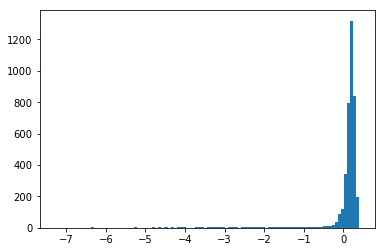

In [9]:
bins, vals, patches = plt.hist(np.log10(np.concatenate((Nbodymind1s, Nbodymind2s))), bins=100)

# Dimensionalize

Iterate following procedure

- Draw a primary from the (single star?) IMF
- Determine stellar type, draw from single/binary. If single, add mass to single/wide binary mass bin and start over
- Draw a random Nbody simulation to get mass ratio, eccentricity and minimum distances
- Draw binary separation from Duchene and Kraus and dimensionalize minds
- If the separation is larger than our wide binary cut off, add the mass to the 'single/wide binary' bin and start over
- From the eccentricity and separation calculate the critical instability distance
- Use the mass-luminosity relation fit for both the primary and secondary to calculate the snow line distance

# Build a sampler

This class let's you sample from an arbitrary pdf

In [10]:
class Sampler():
    def __init__(self, values, pdf): 
        # pass np. array of x values, np.array of pdf at those values
        self.minvalue = values.min()
        self.maxvalue = values.max()
        pdf /= pdf.sum()
        cdf = np.cumsum(pdf)
        self.mincdf = cdf.min()
        self.maxcdf = cdf.max()
        self.cdffunc = interp1d(values, cdf)
        self.invcdffunc = interp1d(cdf, values)
        
        def _sample(cdfval): # returns value corresponding to when cdf matches passed value
            try:
                return self.invcdffunc(cdfval)
            except ValueError:
                if cdfval < self.mincdf:
                    return self.minvalue
                elif cdfval > self.maxcdf:
                    return self.maxvalue
        self._sample = np.vectorize(_sample)
    
    def sample(self, Nvals=1, minval=None, maxval=None):
        # returns Nvals samples from the pdf as np.array. Optionally pass range of values to sample from
        
        # if range of values is passed, calculate corresponding range of cdf values
        mincdf = self.cdffunc(minval) if minval is not None else 0.
        maxcdf = self.cdffunc(maxval) if maxval is not None else 1.
        cdfs = mincdf + (maxcdf-mincdf)*np.random.random([Nvals]) # sample Nvals cdf values in the range
        return self._sample(cdfs)

PDF for the log mass for the binary system

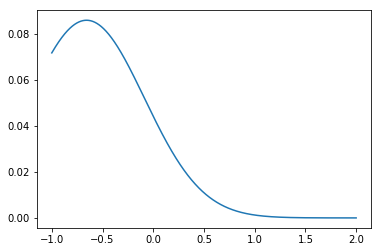

In [11]:
def logIMFChab(logM):
    IMFChab = 0.086*np.exp(-((logM-np.log10(0.22))**(2.))/(2.*0.57**2.))
    return IMFChab

starmasses = np.linspace(-1, 2, 100000)
logIMF = logIMFChab(starmasses)
plt.plot(starmasses, logIMF)
plt.show()

Example over whole range

CPU times: user 308 ms, sys: 5.56 ms, total: 313 ms
Wall time: 315 ms


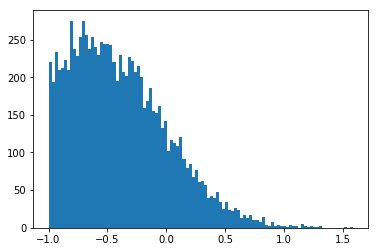

In [12]:
%%time
logIMFsampler = Sampler(starmasses, logIMF)
bins, vals, patches = plt.hist(logIMFsampler.sample(10000), bins=100)

Example over specified range

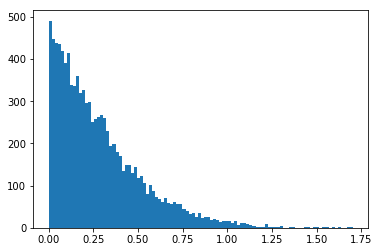

In [13]:
bins, vals, patches = plt.hist(logIMFsampler.sample(10000, 0, 2), bins=100)

# Define stellar types, mass ranges, and multiple fraction

In [14]:
# triplets of [Mmin, Mmax, fraction of systems that are multiples (MF in Duchene & Kraus)]
typemasses = {'VLM':[1.e-3, 0.1, 0.22], 'M':[0.1, 0.6, 0.26], 'FGK':[0.6, 1.4, 0.44], 'A':[1.4, 6.5, 0.5], 'OB':[6.5, 100, 0.7]}

def get_type(M):
    for key, value in typemasses.items():
        if M >= value[0] and M < value[1]:
            return key
    if M < typemasses['VLM'][0]:
        return 'VLM'
    elif M > typemasses['OB'][1]:
        return 'OB'
    print('get_type function didnt catch mass in any bin. M = {0}'.format(M))

# Draw a primary from the IMF (Note this is currently using the system IMF)

In [15]:
results = {'VLM':{'msingleWB':0., 'mCB':0.}, 'M':{'msingleWB':0., 'mCB':0.}, 'FGK':{'msingleWB':0., 'mCB':0.}, 'A':{'msingleWB':0., 'mCB':0.}, 'OB':{'msingleWB':0., 'mCB':0.}}

In [16]:
Mprimary = 10**logIMFsampler.sample()[0] # returns array
print(Mprimary)

0.447340696277


# Determine stellar type, draw from single/binary and add mass to single/wide binary mass bin if single

In [17]:
startype = get_type(Mprimary)
mf = typemasses[startype][2]
print(startype, mf)

M 0.26


In [18]:
randfloat = np.random.random()
print(randfloat)
if randfloat > mf:
    results[startype]['msingleWB'] += Mprimary
results[startype]

0.09241710264173564


{'mCB': 0.0, 'msingleWB': 0.0}

# Draw a random Nbody simulation to get mass ratio, eccentricity and minimum distances

In [19]:
randseed = np.random.randint(len(seeds))
mind1 = Nbodymind1s[randseed]
mind2 = Nbodymind2s[randseed]
mratio = mratios[randseed] # secondary has mass mratio
ebin = ebinarys[randseed]
print(mind1, mind2, mratio, ebin)

1.86952289542 1.58772152211 0.780139722834 0.139859310434


In [20]:
M1 = Mprimary
M2 = M1*mratio
print(M1, M2)

0.447340696277 0.348988246806


# Draw binary separation from Duchene and Kraus and dimensionalize minds

Define Duchene & Kraus binary separation distributions

In [21]:
logabinaries = np.linspace(-2.5, 6, 10000)
def gaussianpdf(vals, mu, sigma):
    pdf = np.exp(-(vals-mu)**2/(2.*sigma**2))
    return pdf/pdf.sum()

In [22]:
logabinPDF = {}
logabinPDF['VLM'] = 0.6*gaussianpdf(logabinaries, np.log10(4.5), 0.333)
logabinPDF['M'] = 0.9*gaussianpdf(logabinaries, np.log10(5.3), 0.867)
logabinPDF['FGK'] = 1.8*gaussianpdf(logabinaries, np.log10(45), 1.533)

tempA = 2.1*gaussianpdf(logabinaries, 2.5, 1.65) + 0.8*gaussianpdf(logabinaries, -0.85, .5)
logabinPDF['A'] = tempA

def OBpdf(logabin):
    mu = -0.75
    sigma = 0.36
    sw = -0.3 # switch
    if logabin < -0.3: 
        return np.exp(-(logabin-mu)**2/(2.*sigma**2))
    else:
        return np.exp(-(sw-mu)**2/(2.*sigma**2))-0.05*(logabin-sw)
logabinPDF['OB'] = np.array([OBpdf(logabin) for logabin in logabinaries])
logabinPDF['OB'] = 3*logabinPDF['OB']/logabinPDF['OB'].sum()

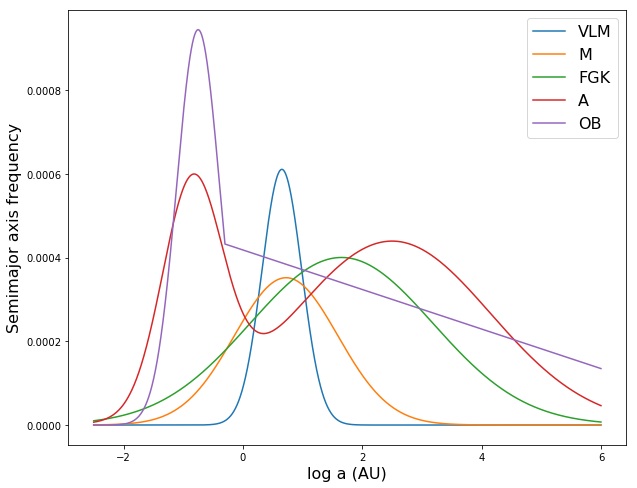

In [23]:
fig, ax = plt.subplots(figsize=(10,8))
for key, val in logabinPDF.items():
    ax.plot(logabinaries, val, label=key)
plt.legend(fontsize=16)
ax.set_xlabel('log a (AU)', fontsize=16)
ax.set_ylabel('Semimajor axis frequency', fontsize=16)

Duchene and Kraus give binary separation distributions based on primary mass, so get primary stellar type from M1 (should be same as stellartype chosen for system above in most cases)

Create sampler for particular stellartype

CPU times: user 401 ms, sys: 8.84 ms, total: 410 ms
Wall time: 465 ms


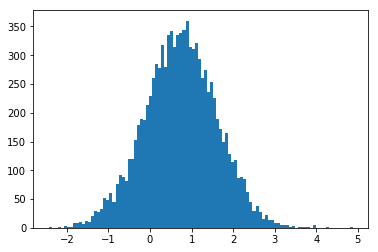

In [24]:
%%time
logabinsampler = Sampler(logabinaries, logabinPDF[startype])
bins, vals, patches = plt.hist(logabinsampler.sample(10000), bins=100)

In [25]:
abinary = 10**logabinsampler.sample()[0]
mind1 *= abinary
mind2 *= abinary
print(abinary, mind1, mind2)

18.0010260822 33.6533304017 28.5806165308


# If the separation is larger than our wide binary cut off, add the mass to the 'single/wide binary' bin and start over

In [26]:
def acritprimary(mu, ebin): # Holman & Wiegert 99 for the critical semimajor axis around each star
    return 0.464 - 0.38*mu - 0.631*ebin +0.586*ebin*mu + 0.15*ebin**2 -0.198*ebin**2*mu

In [27]:
acp = acritprimary(mratio, ebin)*abinary
acp

2.5767863113810145

In [28]:
aWBcutoff = 10.
if acp > aWBcutoff:
    results[startype]['msingleWB'] += M1 + M2
else:
    results[startype]['mCB'] += M1 + M2

# From the eccentricity and separation calculate the critical instability distance

In [29]:
def acritcbp(mu, ebin): # Holman & Wiegert 99 for P type circumbinary
    return 1.60 + 5.10*ebin -2.22*ebin**2 + 4.12*mu -4.27*ebin*mu -5.09*mu**2 + 4.61*ebin**2*mu**2 

In [30]:
acrit = acritcbp(mratio, ebin)*abinary
acrit

35.554743763648162

# Use the mass-luminosity relation fit for both the primary and secondary to calculate the snow line distance

First get fitting functions to get radius and luminosities at 1 Myr

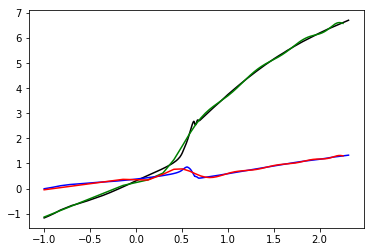

In [31]:
# Stellar tracks fits: L(M) and R(M)

# Read the stellar tracks file with pandas. This is the only file needed
tracksdf = pd.read_table('./startrackextended.txt', header=0,delimiter=r"\s+")


# Fit log_L then log_R as a function of log(mass) using polynomials
FitLfuncM = np.polyfit(np.log10(tracksdf['star_mass']), tracksdf['log_L'], 16)
FitRfuncM = np.polyfit(np.log10(tracksdf['star_mass']), tracksdf['log_R'], 20)


# Convenience function to easily call the polynomials as functions 
# These are the functions you will need to use
# example: Luminosity for a 1 solar mass star: PolyLfuncM(np.log10(1.))
# It hence takes logs and output logs
PolyLfuncM = np.poly1d(FitLfuncM)
PolyRfuncM = np.poly1d(FitRfuncM)



############################## PLOT ############################
# stellar mass array
arraytest = np.linspace(0.1,180.,len(tracksdf['log_L']))

# Compare fit and data for L func of M
plt.plot(np.log10(tracksdf['star_mass']),tracksdf['log_L'], color='black')
plt.plot(np.log10(arraytest),PolyLfuncM(np.log10(arraytest).reshape((len(arraytest),1))), color='green')

# Compare fit and data for R func of M
plt.plot(np.log10(tracksdf['star_mass']),tracksdf['log_R'], color='blue')
plt.plot(np.log10(arraytest),PolyRfuncM(np.log10(arraytest).reshape((len(arraytest),1))), color='red')

plt.show()
############################## END sPLOT ############################

In [32]:
# all in SI
Lsun = 3.828e26
Tice = 150
sbconst = 5.67e-8
AU = 1.496e11
def Lstar(Mstar): # Returns radius of star in AU at time interpolated in cell above
    if Mstar < 0.1: # function can't interpolate below 0.1
        Mstar = 0.1
    return 10**PolyLfuncM(np.log10(Mstar))*Lsun

In [33]:
Ltot = Lstar(M1) + Lstar(M2)
aice = np.sqrt(Ltot/(np.pi*sbconst))/(2.*Tice**2)/AU
aice

6.4395641639892283

# Calculate a_Roche and Rstar from M

In [34]:
Rsun = 5e-3 # AU
def aRoche(Mstar): # assumes fluid body (coeff of 1.26) and a bulk density for the body of 3 g/cc
    rho_sun = 1.4
    rho_body = 3
    return 1.26*Mstar**(1./3.)*(rho_sun/rho_body)**(1./3.)*Rsun # Return value in AU

def Rstar(Mstar): # Returns radius of star in AU at time interpolated in cell above
    if Mstar < 0.1: # function can't interpolate below 0.1
        Mstar = 0.1
    return 10**PolyRfuncM(np.log10(Mstar))*Rsun

In [35]:
aRoches = np.array([aRoche(10**M) for M in starmasses])/Rsun
Rstars = np.array([Rstar(10**M) for M in starmasses])/Rsun

# The Roche Limit is inside the stars for all values of the mass at 1 Myr. Presumably the Roche Limit is outside low-mass stars once they have contracted? Worth checking?

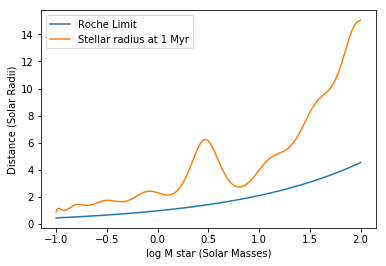

In [36]:
fig, ax = plt.subplots()
ax.plot(starmasses, aRoches, label='Roche Limit')
ax.plot(starmasses, Rstars, label='Stellar radius at 1 Myr')
ax.legend()
ax.set_xlabel('log M star (Solar Masses)')
ax.set_ylabel('Distance (Solar Radii)')

In [37]:
R1 = Rstar(M1)
R2 = Rstar(M2)
aRoche1 = aRoche(M1)
aRoche2 = aRoche(M2)
print(R1, R2, aRoche1, aRoche2)

0.00827518408627 0.00867691967798 0.0037372797947 0.00344043277907


# Put above steps all together in a function

In [38]:
def sample():
    Mprimary = 10**logIMFsampler.sample()[0] # returns array
    startype = get_type(Mprimary)
    mf = typemasses[startype][2]
    randfloat = np.random.random()
    if randfloat > mf:
        r[startype]['msingleWB'] += Mprimary
        return 0
    
    # draw random Nbody simulation and get dimensoinalized masses from Msystem
    randseed = np.random.randint(len(seeds))
    mind1 = Nbodymind1s[randseed]
    mind2 = Nbodymind2s[randseed]
    mratio = mratios[randseed] # secondary has mass mratio
    ebin = ebinarys[randseed]
    M1 = Mprimary
    M2 = M1*mratio

    # get primary stellar type and create abinary sampler to get abinary and dimensionalize minds
    logabinsampler = Sampler(logabinaries, logabinPDF[startype])
    abinary = 10**logabinsampler.sample()[0]
    mind1 *= abinary
    mind2 *= abinary

    acp = acritprimary(mratio, ebin)*abinary
    if acp > aWBcutoff:
        r[startype]['msingleWB'] += M1 + M2
        return 1
    else:
        r[startype]['mCB'] += M1 + M2
    
    acrit = acritcbp(mratio, ebin)*abinary
    Ltot = Lstar(M1) + Lstar(M2)
    aice = np.sqrt(Ltot/(np.pi*sbconst))/(2.*Tice**2)/AU
    
    # calculate radii and roche limits
    R1 = Rstar(M1)
    R2 = Rstar(M2)
    aRoche1 = aRoche(M1)
    aRoche2 = aRoche(M2)
    
    q = r[startype]
    q['abinaries'].append(abinary)
    q['mind1s'].append(mind1)
    q['mind2s'].append(mind2)
    q['R1s'].append(R1)
    q['R2s'].append(R2)
    q['aRoche1s'].append(aRoche1)
    q['aRoche2s'].append(aRoche2)
    q['acrits'].append(acrit)
    q['aices'].append(aice)
    q['M1s'].append(M1)
    q['M2s'].append(M2)

    return 2

# Sample

In [39]:
%%time
startypes = ['VLM', 'M', 'FGK', 'A', 'OB']
fields = ['abinaries', 'mind1s', 'mind2s', 'R1s', 'R2s', 'aRoche1s', 'aRoche2s', 'acrits', 'aices', 'M1s', 'M2s']
r = {}
for startype in startypes:
    r[startype] = {'msingleWB':0., 'mCB':0.}
    for field in fields:
        r[startype][field] = []

Nsamples = 1000000
samples = np.array([sample() for i in range(Nsamples)])

CPU times: user 5min 7s, sys: 7.5 s, total: 5min 14s
Wall time: 5min 16s


# Distribution of binarity type

(array([ 677289.,       0.,       0.,       0.,       0.,   76939.,
              0.,       0.,       0.,  245772.]),
 array([ 0. ,  0.2,  0.4,  0.6,  0.8,  1. ,  1.2,  1.4,  1.6,  1.8,  2. ]),
 <a list of 10 Patch objects>)

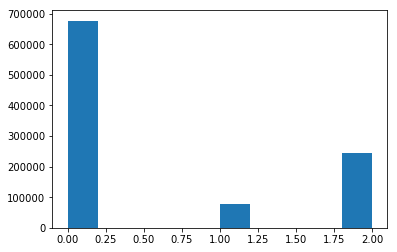

In [40]:
plt.hist(samples)

In [41]:
print("{0}/{1} = {2:.4f} singles".format((samples==0).sum(), len(samples), (samples==0).sum()/float(len(samples))))
print("{0}/{1} = {2:.4f} wide binaries".format((samples==1).sum(), len(samples), (samples==1).sum()/float(len(samples))))
print("{0}/{1} = {2:.4f} tight binaries".format((samples==2).sum(), len(samples), (samples==2).sum()/float(len(samples))))

677289/1000000 = 0.6773 singles
76939/1000000 = 0.0769 wide binaries
245772/1000000 = 0.2458 tight binaries


# Total Mass breakdown

In [42]:
msingleWB = np.array([r[startype]['msingleWB'] for startype in startypes]).sum()
mCB = np.array([r[startype]['mCB'] for startype in startypes]).sum()
print("Mass in circumbinaries vs singles/wide binaries = {0}".format(mCB/msingleWB))

print("Mass in circumbinaries per stellar type")
for startype in startypes:
    print("{0} in {1}".format(r[startype]['mCB']/mCB, startype))

Mass in circumbinaries vs singles/wide binaries = 0.5260666259254204
Mass in circumbinaries per stellar type
0.0 in VLM
0.22936707883562502 in M
0.2327142907807487 in FGK
0.36699734942671286 in A
0.17092128095691334 in OB


# Distribution of Stellar Radii

Peak at low values for M stars is because most secondaries have M < 0.1, which is outside interpolation range for stellar radii, so they're assigned R(M=0.1)

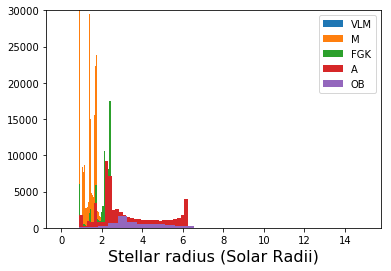

In [61]:
fig, ax = plt.subplots()
for startype in startypes:
    R1s = np.array(r[startype]['R1s'])
    R2s = np.array(r[startype]['R2s'])
    bins, vals, patches = ax.hist(np.concatenate((R1s/Rsun, R2s/Rsun)), bins=30, label=startype)
ax.set_xlabel('Stellar radius (Solar Radii)', fontsize=16)
ax.set_ylim([0,30000])
ax.legend()

# Distribution of Roche Limits

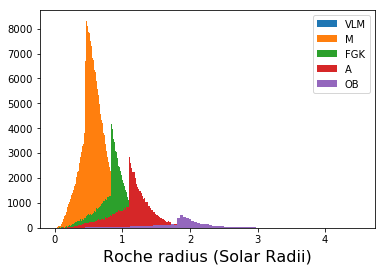

In [62]:
fig, ax = plt.subplots()
for startype in startypes:
    aRoche1s = np.array(r[startype]['aRoche1s'])
    aRoche2s = np.array(r[startype]['aRoche2s'])
    bins, vals, patches = ax.hist(np.concatenate((aRoche1s/Rsun, aRoche2s/Rsun)), bins=100, label=startype)
ax.set_xlabel('Roche radius (Solar Radii)', fontsize=16)
ax.legend()

# Distribution of binary separations

For OB, part of the tail toward large separations is due to drawing an OB system mass, but then ending up with a primary that is an A star due to random draw of mass ratio

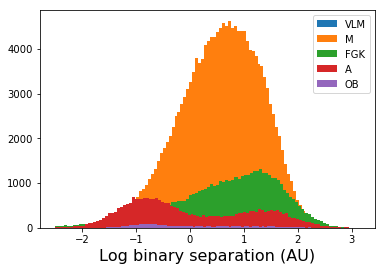

In [63]:
fig, ax = plt.subplots()
for startype in startypes:
    logabin = np.log10(r[startype]['abinaries'])
    bins, vals, patches = ax.hist(logabin, bins=100, label=startype)
ax.set_xlabel('Log binary separation (AU)', fontsize=16)
ax.legend()

# Distribution of log min distances in units of stellar radii

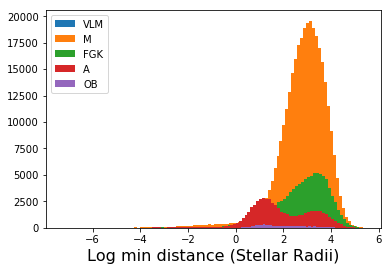

In [64]:
fig, ax = plt.subplots()
for startype in startypes:
    logd1Rs = np.log10(np.array(r[startype]['mind1s'])/np.array(r[startype]['R1s']))
    logd2Rs = np.log10(np.array(r[startype]['mind2s'])/np.array(r[startype]['R2s']))
    ds = np.concatenate([logd1Rs, logd2Rs])
    bins, vals, patches = ax.hist(ds, bins=100, label=startype)
ax.set_xlabel('Log min distance (Stellar Radii)', fontsize=16)
ax.legend()

In [65]:
print("Number of collisions:")
for startype in startypes:
    logd1Rs = np.log10(np.array(r[startype]['mind1s'])/np.array(r[startype]['R1s']))
    logd2Rs = np.log10(np.array(r[startype]['mind2s'])/np.array(r[startype]['R2s']))
    ds = np.concatenate([logd1Rs, logd2Rs])
    print("{0}: {1}/{2} = {3}".format(startype, (ds < 0).sum(), len(ds), (ds < 0).sum()/float(len(ds))))

Number of collisions:
VLM: 0/0 = nan
M: 6685/328188 = 0.02036942240423172
FGK: 2556/100506 = 0.025431317533281594
A: 2293/56752 = 0.040403862418945585
OB: 189/6098 = 0.030993768448671695


/anaconda/envs/p3/lib/python3.6/site-packages/ipykernel/__main__.py:6: RuntimeWarning: invalid value encountered in true_divide


# Distribution of log min distances in units of Roche radii

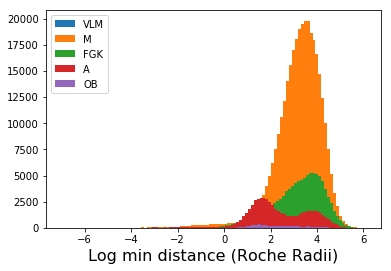

In [66]:
fig, ax = plt.subplots()
for startype in startypes:
    logd1Roches = np.log10(np.array(r[startype]['mind1s'])/np.array(r[startype]['aRoche1s']))
    logd2Roches = np.log10(np.array(r[startype]['mind2s'])/np.array(r[startype]['aRoche2s']))
    ds = np.concatenate([logd1Roches, logd2Roches])
    bins, vals, patches = ax.hist(ds, bins=100, label=startype)
ax.set_xlabel('Log min distance (Roche Radii)', fontsize=16)
ax.legend()

# Can tidal disruptions even occur?

Check how many samples had Roche radius outside stellar radius

In [67]:
print("Number of disruptions:")
for startype in startypes:
    logd1Roches = np.log10(np.array(r[startype]['mind1s'])/np.array(r[startype]['aRoche1s']))
    logd2Roches = np.log10(np.array(r[startype]['mind2s'])/np.array(r[startype]['aRoche2s']))
    ds = np.concatenate([logd1Roches, logd2Roches])
    fracs = np.concatenate((np.array(r[startype]['aRoche1s'])/np.array(r[startype]['R1s']), np.array(r[startype]['aRoche2s'])/np.array(r[startype]['R2s'])))
    mask = ds < 0
    disruptioncandidates = ds[mask]
    print("{0}: {1}/{2} = {3}".format(startype, (disruptioncandidates > 1).sum(), len(ds), (disruptioncandidates > 1).sum()/float(len(ds))))

Number of disruptions:
VLM: 0/0 = nan
M: 0/328188 = 0.0


/anaconda/envs/p3/lib/python3.6/site-packages/ipykernel/__main__.py:9: RuntimeWarning: invalid value encountered in true_divide


FGK: 0/100506 = 0.0
A: 0/56752 = 0.0
OB: 0/6098 = 0.0


# Ice Lines

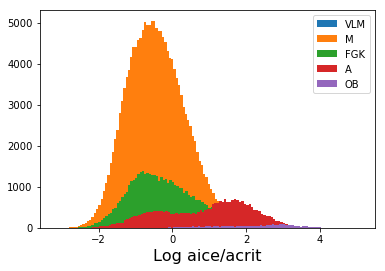

In [69]:
fig, ax = plt.subplots()
for startype in startypes:
    logaice = np.log10(np.array(r[startype]['aices'])/np.array(r[startype]['acrits']))
    bins, vals, patches = ax.hist(logaice, bins=100, label=startype)
ax.set_xlabel('Log aice/acrit', fontsize=16)
ax.legend()

# Mass weighted ice lines

In [70]:
Nbins = 99
bins = np.linspace(-4, 5, Nbins, endpoint=False)
spacing = bins[1]-bins[0]

In [71]:
vals = {}
for startype in startypes:
    vals[startype] = np.zeros(Nbins)
totvals = np.zeros(Nbins)
    
for startype in startypes:
    logaices = np.log10(np.array(r[startype]['aices'])/np.array(r[startype]['acrits']))
    Mtots = np.array(r[startype]['M1s']) + np.array(r[startype]['M2s'])
    for logaice, Mtot in zip(logaices, Mtots):
        for i, b in enumerate(bins):
            if logaice >= b and logaice < b+spacing:
                vals[startype][i] += Mtot
                totvals[i] += Mtot

# Total mass weighted ice line distribution 

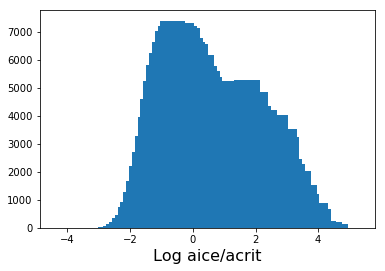

In [72]:
fig, ax = plt.subplots()
ax.bar(bins, totvals)
ax.set_xlabel('Log aice/acrit', fontsize=16)

In [73]:
t = np.array(totvals)
tot = t.sum()

print('Fraction of mass with ice line > acrit = {0}'.format(t[(bins > 0)].sum()/tot))

Fraction of mass with ice line > acrit = 0.5951029664138955


# Mass weighted ice line distribution broken down by stellar type

/anaconda/envs/p3/lib/python3.6/site-packages/ipykernel/__main__.py:6: RuntimeWarning: invalid value encountered in double_scalars


VLM: Fraction of mass with ice line > acrit = nan
M: Fraction of mass with ice line > acrit = 0.28048538593492023
FGK: Fraction of mass with ice line > acrit = 0.37393512922214417
A: Fraction of mass with ice line > acrit = 0.7506682790735534
OB: Fraction of mass with ice line > acrit = 0.9853004139519941


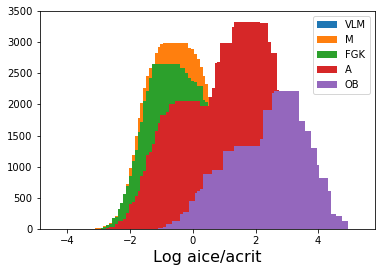

In [74]:
fig, ax = plt.subplots()
for startype in startypes:
    ax.bar(bins, vals[startype], label=startype)
    t = np.array(vals[startype])
    tot = t.sum()
    print('{0}: Fraction of mass with ice line > acrit = {1}'.format(startype, t[(bins > 0)].sum()/tot))
ax.set_xlabel('Log aice/acrit', fontsize=16)
ax.legend()